# Mount the My Drive folder

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)

Mounted at /gdrive


# Env setup

In [ ]:
%cd /gdrive/MyDrive/AAIB

/gdrive/.shortcut-targets-by-id/1zB7lUkUl6sh9CmqtafBeUachtR7FmmTD/AAIB


In [ ]:
# !unzip "assigment_test_set/test_set.zip"

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from google.colab import drive
import tensorflow as tf
import numpy as np

import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,array_to_img
from sklearn.metrics import confusion_matrix
from keras.callbacks import *
import random
from keras import backend as K
from PIL import Image
import cv2
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfk = tf.keras
tfkl = tf.keras.layers
from itertools import combinations
import json
import scipy
from skimage import filters
from keras.models import load_model
from typing import Tuple, List
import albumentations as A
from sklearn.metrics import classification_report
from skimage.measure import label as label_fn

import scipy.ndimage

In [ ]:
SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

labels_path = '/gdrive/MyDrive/AAIB/'

img_size = (224,224)
batch_size = 1024

# Pair reduction

In [ ]:
def folderToPaths(
        full_img_dir,
        full_path = True
):

    x_paths_list = []

    full_img_dir = full_img_dir



    for full in os.listdir(full_img_dir):
      if '.jpeg' in full or '.png' in full:
          if full_path:
              x_paths_list.append(os.path.join(full_img_dir, full))
          else:
              x_paths_list.append(full)
    
    x_paths_list.sort()
    return x_paths_list

In [ ]:
def filterTuples(l: list,
                 fileFormatDiscriminator: str = 'png',
                 pos1: int = -5,
                 pos2: int = -6,
                 idFile1: str = '1',
                 idFile2: str = '2'):
    tuples = []
    singletons = []
    for idx in range(1, len(l)):
        start1 = pos1 if fileFormatDiscriminator in l[idx - 1] else pos2
        start2 = pos1 if fileFormatDiscriminator in l[idx] else pos2
        id1 = l[idx - 1][start1]
        id2 = l[idx][start2]
        if id1 == idFile1 and id2 == idFile2:
            tuples.append((l[idx - 1], l[idx]))
        elif id1 == idFile1:
            singletons.append(l[idx - 1])

            if idx == len(l) - 1:
                singletons.append(l[idx])

    return singletons, tuples

def checkTuples(tuples: List[tuple], patientIDLength: int = 6):
    for t in tuples:
        assert t[0][:6] == t[1][:6]


def checkLength(tuples: List[tuple], singletons: list, targetLen: int):
    assert 2 * len(set(tuples)) + len(set(singletons)) == targetLen


def detectNoisyImagesPaths(path1, path2, folderPath):
    im1 = cv2.imread(os.path.join(folderPath, path1), flags = cv2.IMREAD_GRAYSCALE)
    im1 = scipy.ndimage.gaussian_laplace(im1, sigma = 1)

    im2 = cv2.imread(os.path.join(folderPath, path2), flags = cv2.IMREAD_GRAYSCALE)
    im2 = scipy.ndimage.gaussian_laplace(im2, sigma = 1)

    sum1 = np.sum(im1)
    sum2 = np.sum(im2)

    if sum1 > sum2:
        return path1
    elif sum2 > sum1:
        return path2

    else:
        return None


def detectBlurredImagesPaths(path1, path2, folderPath):
    im1 = cv2.imread(os.path.join(folderPath, path1), flags = cv2.IMREAD_GRAYSCALE)
    im1 = scipy.ndimage.gaussian_laplace(im1, sigma = 1)

    im2 = cv2.imread(os.path.join(folderPath, path2), flags = cv2.IMREAD_GRAYSCALE)
    im2 = scipy.ndimage.gaussian_laplace(im2, sigma = 1)

    var1 = np.var(im1)
    var2 = np.var(im2)

    if var1 < var2:
        return path1
    elif var2 < var1:
        return path2

    else:
        return None


def getNoisyImagesPaths(tuples, folderPath):
    cleanImagesPaths = []

    for idx, t in enumerate(tuples):
        p = detectNoisyImagesPaths(path1 = t[0], path2 = t[1], folderPath = folderPath)

        if p is not None:
            cleanImagesPaths.append(p)

    return cleanImagesPaths


def getBlurredImagesPaths(tuples, folderPath):
    cleanImagesPaths = []

    for idx, t in enumerate(tuples):
        #print(idx)
        p = detectBlurredImagesPaths(path1 = t[0], path2 = t[1], folderPath = folderPath)

        if p is not None:
            cleanImagesPaths.append(p)

    return cleanImagesPaths

In [ ]:
paths = folderToPaths(labels_path, False)
singletons, tuples = filterTuples(paths)

# some checks just to be sure
checkTuples(tuples)
checkLength(tuples = tuples, singletons = singletons, targetLen = 5144)

In [10]:
noisyImagesPaths = getNoisyImagesPaths(tuples = tuples, folderPath = labels_path)

In [11]:
noisyImagesPaths

['P00009_2.jpeg',
 'P00015_1.png',
 'P00025_1.png',
 'P00028_2.jpeg',
 'P00032_1.png',
 'P00033_2.jpeg',
 'P00041_1.png',
 'P00045_1.jpeg',
 'P00052_1.png',
 'P00068_1.jpeg',
 'P00080_2.jpeg',
 'P00081_2.png',
 'P00083_1.png',
 'P00087_2.png',
 'P00093_2.jpeg',
 'P00096_2.jpeg',
 'P00101_2.jpeg',
 'P00113_1.png',
 'P00115_1.png',
 'P00120_1.png',
 'P00140_1.png',
 'P00152_1.png',
 'P00162_1.png',
 'P00165_1.png',
 'P00173_2.jpeg',
 'P00174_1.jpeg',
 'P00176_1.jpeg',
 'P00207_1.jpeg',
 'P00213_2.jpeg',
 'P00215_1.jpeg',
 'P00246_2.png',
 'P00252_2.png',
 'P00257_1.jpeg',
 'P00263_2.png',
 'P00264_1.png',
 'P00265_1.png',
 'P00269_1.jpeg',
 'P00285_1.jpeg',
 'P00298_2.png',
 'P00299_1.jpeg',
 'P00310_1.png',
 'P00314_1.jpeg',
 'P00318_2.png',
 'P00320_1.png',
 'P00326_1.jpeg',
 'P00335_2.png',
 'P00341_1.png',
 'P00347_2.jpeg',
 'P00351_1.jpeg',
 'P00365_1.jpeg',
 'P00375_2.png',
 'P00380_1.jpeg',
 'P00392_2.jpeg',
 'P00398_2.png',
 'P00412_1.png',
 'P00423_1.jpeg',
 'P00428_2.png',
 'P0

In [12]:
imagesToKeep = [x for x in paths if x not in noisyImagesPaths]

## 5144 -> 4029

In [13]:
len(imagesToKeep)

4029

# Data generator

In [14]:
class CustomGenerator(tf.keras.utils.Sequence):
  """
    CustomGenerator inheriting from tf.mkeras.utils.Sequence.

    We have to implement 3 main methods:
      - __init__: save dataset params like directory, filenames, etc.
      - __len__: return the total number of samples in the dataset (number of batches)
      - __getitem__: return a single batch of paired images masks
  """

  def __init__(self, 
               dataframe, # dataframe of the dataset  
               base_path,
               preprocessing_function=None, # Preprocessing function (e.g., the one used for transfer learning)
               batch_size=16, # Batch size
               out_shape = (100,100),
               shuffle=False,
               categorical = True,
               augment = False,
               seed = SEED,
               flow_from_directory = True,
               preprocess_input = False,
               with_labels = True):
    

    self.with_labels = with_labels
    
    # Get all filenames
    if isinstance(base_path, Tuple):
      self.filenames = []
      for p in base_path:

        paths = self.folderToPaths(p, full_path = False)

        for pa in paths:
          if pa in set(dataframe.file):
            self.filenames.append(os.path.join(p, pa))


    else:
        self.filenames = [os.path.join(base_path, img_path) for img_path in list(dataframe.file)]

    if self.with_labels:
      self.labels = tfk.utils.to_categorical(list(dataframe.label)) if categorical else list(dataframe.label)

    # Set indices list in [0, len(subset_filenames)]
    self.indices = np.arange(len(self.filenames))

    # Save dataset parameters as class attributes
    self.base_path = base_path
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.augment = augment
    self.seed = seed
    self.flow_from_directory =flow_from_directory
    self.data_augmentation = A.Compose([
    A.RandomBrightnessContrast(brightness_limit = 0.05, contrast_limit=0.05, p=0.5),
    A.ShiftScaleRotate(p = 0.8, rotate_limit = 20, scale_limit = 0.3, border_mode =  cv2.BORDER_CONSTANT, value = 0),
    A.CLAHE(p=0.2)
    ])
    self.preprocess_input = preprocess_input

    if not self.flow_from_directory:
      self.images = self.load_all_imgs()

  def augmentation(self, images):
    return self.data_augmentation(image = images)


  def __filterNoisyOnClahe(self, image):
    clahe = cv2.createCLAHE(clipLimit = 300, tileGridSize = (50, 50))
    im1 = cv2.resize(image, (400, 400))
    im1 = scipy.ndimage.gaussian_laplace(im1, sigma = 6)
    im1 = clahe.apply(im1)
    var1 = np.var(im1)
    if var1 > 800:
      image= cv2.medianBlur(image, ksize=5)
      return scipy.ndimage.uniform_filter(image, size=3)
    else:
      #return cv2.medianBlur(image, ksize=3)
      return image


  def __sharpenImage(self, image):
    sharpen_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

    sharpened = cv2.filter2D(image, -1, sharpen_kernel)
    # sharpened = cv2.filter2D(sharpened, -1, sharpen_kernel)

    return sharpened

  def __invert_image(self, img):

    otsu_thresh = filters.threshold_otsu(img)
    masked_image = (img > otsu_thresh) * 1.0
    valsROI1, _ = np.histogram(masked_image[220:244, 220:244], bins=2, range=(0, 1))
    valsROI2, _ = np.histogram(masked_image[0:25, 0:25], bins=2, range=(0, 1))
    valsROI3, _ = np.histogram(masked_image[0:25, 220:244], bins=2, range=(0, 1))
    valsROI4, _ = np.histogram(masked_image[220:244, 0:25], bins=2, range=(0, 1))
    
    valsTot = valsROI1 + valsROI2 + valsROI3 + valsROI4
    
    labels = label_fn(masked_image)

    if len(np.unique(labels)) < 100:
        if valsTot[0] > valsTot[1]:
            return img
        else:
            return 255 - img
    return img


  def __filterBlurred(self, image):
    clahe = cv2.createCLAHE(clipLimit = 1.8, tileGridSize = (4, 4))
    minThresh = 2
    im1 = cv2.resize(image, (400, 400))
    im1 = scipy.ndimage.gaussian_laplace(im1, sigma = 2)
    im1 = clahe.apply(im1)
    _, im1 = cv2.threshold(im1, minThresh, 255, cv2.THRESH_BINARY)
    var1 = np.var(im1)
    if var1 < 5:
        return self.__sharpenImage(image)
    else:
        return image # 

  def __filterUnderexposed(self, image):
    im1 = cv2.resize(image, (400, 400))
    mean1 = np.mean(im1)
    if mean1 < 71:
      clahe = cv2.createCLAHE(clipLimit = 2, tileGridSize = (2, 2))
      image = clahe.apply(image)
      return image
    else:
      return image


  def preprocess(self, image):

    image = self.__invert_image(image)
    image = self.__filterUnderexposed(image)
    image = self.__filterNoisyOnClahe(image)
    image = self.__filterBlurred(image)
   

    return image

  def __len__(self):
    # Return the length of the dataset (number of batches)
    # that is given by #images // batch_size
    return 1 + len(self.filenames) // self.batch_size 

  """  def on_epoch_start(self):
      # Shuffle indices after each epoch
      if self.shuffle == True:
          np.random.shuffle(self.indices)"""

  def load_all_imgs(self):
      images = []
      for f in self.filenames:
        image = cv2.imread(f, 0)
        image = cv2.resize(image, (self.out_shape))
        if self.preprocess_input:
          image = self.preprocess(image)
        images.append(image)

      return np.array(images)

  def get_image_and_label(self, index):

    if not self.flow_from_directory:
      image = self.images[index]
      if self.augment:
        image = self.augmentation(image)
      image = np.squeeze(image)
      image = np.stack([image, image, image], axis = -1)

      if self.with_labels:
        curr_label = self.labels[index]
    else:
      curr_filename = self.filenames[index] # Get filename at index

      if self.with_labels:
        curr_label = self.labels[index]
      image = cv2.imread(curr_filename, 0)
      image = cv2.resize(image, (self.out_shape))
      if self.preprocess_input:
        image = self.preprocess(image)

      if self.augment:
        image = self.augmentation(image)['image']

      image = np.stack([image, image, image], axis = -1)

    if self.with_labels:
      return image, curr_label
    else:
      return image

  def __getitem__(self, index):
    # In this function we generate a batch (of size self.batch_size) of images and corresponding masks
    
    # Get 'self.batch_size' indices
    current_indices = self.indices[index*self.batch_size:(index*self.batch_size)+self.batch_size]

    # Init lists that will contain images and masks
    batch_images = []
    batch_labels = []

    # Cycle over the indices
    for idx in current_indices:
      # Get single image/mask at index 'idx'
      if self.with_labels:
        image, label = self.get_image_and_label(idx)
      else:
        image = self.get_image_and_label(idx)

      # Apply the preprocessing function
      if self.preprocessing_function is not None:
        image = self.preprocessing_function(image)

      # Append both image and mask (with added batch dimension) to the corresponding batch lists
      batch_images.append(np.expand_dims(image, 0))

      if self.with_labels:
        batch_labels.append(label)

    if not self.with_labels:
      return np.concatenate(batch_images, axis=0)
     
    # Finally, obtain a final batch by concatenating all the images over the batch dimension
    batch_images = np.concatenate(batch_images, axis=0)
    batch_labels = np.array(batch_labels)

    return batch_images, batch_labels


  def folderToPaths(
        self,
        full_img_dir,
        full_path = True
):

    x_paths_list = []

    full_img_dir = full_img_dir

    for full in os.listdir(full_img_dir):
         if full_path:
            x_paths_list.append(os.path.join(full_img_dir, full))
         else:
          x_paths_list.append(full)
    
    x_paths_list.sort()
    return x_paths_list

# Data loading

In [15]:
def decode(x):
  if x == 0:
    return 'N'
  elif x == 1:
    return 'P'
  else:
    return 'T'

In [16]:
img_names = folderToPaths(labels_path, False) # these will be used later for the final csv

In [17]:
labelsDict = {
    'file': imagesToKeep,
    'label': ['None' for _ in range(len(imagesToKeep))]
}

In [18]:
labelsDF = pd.DataFrame.from_dict(labelsDict)

In [19]:
labelsDF

,file,label
0,P00009_1.jpeg,None
1,P00015_2.png,None
2,P00017_1.png,None
3,P00018_1.png,None
4,P00019_1.png,None
...,...,...
4024,P16074_1.jpeg,None
4025,P16084_1.jpeg,None
4026,P16086_1.jpeg,None
4027,P16093_1.png,None


In [35]:
test_gen = CustomGenerator(dataframe = labelsDF, base_path = labels_path, batch_size = 64, out_shape = img_size, flow_from_directory=True, preprocess_input = True, augment = False, with_labels=False)

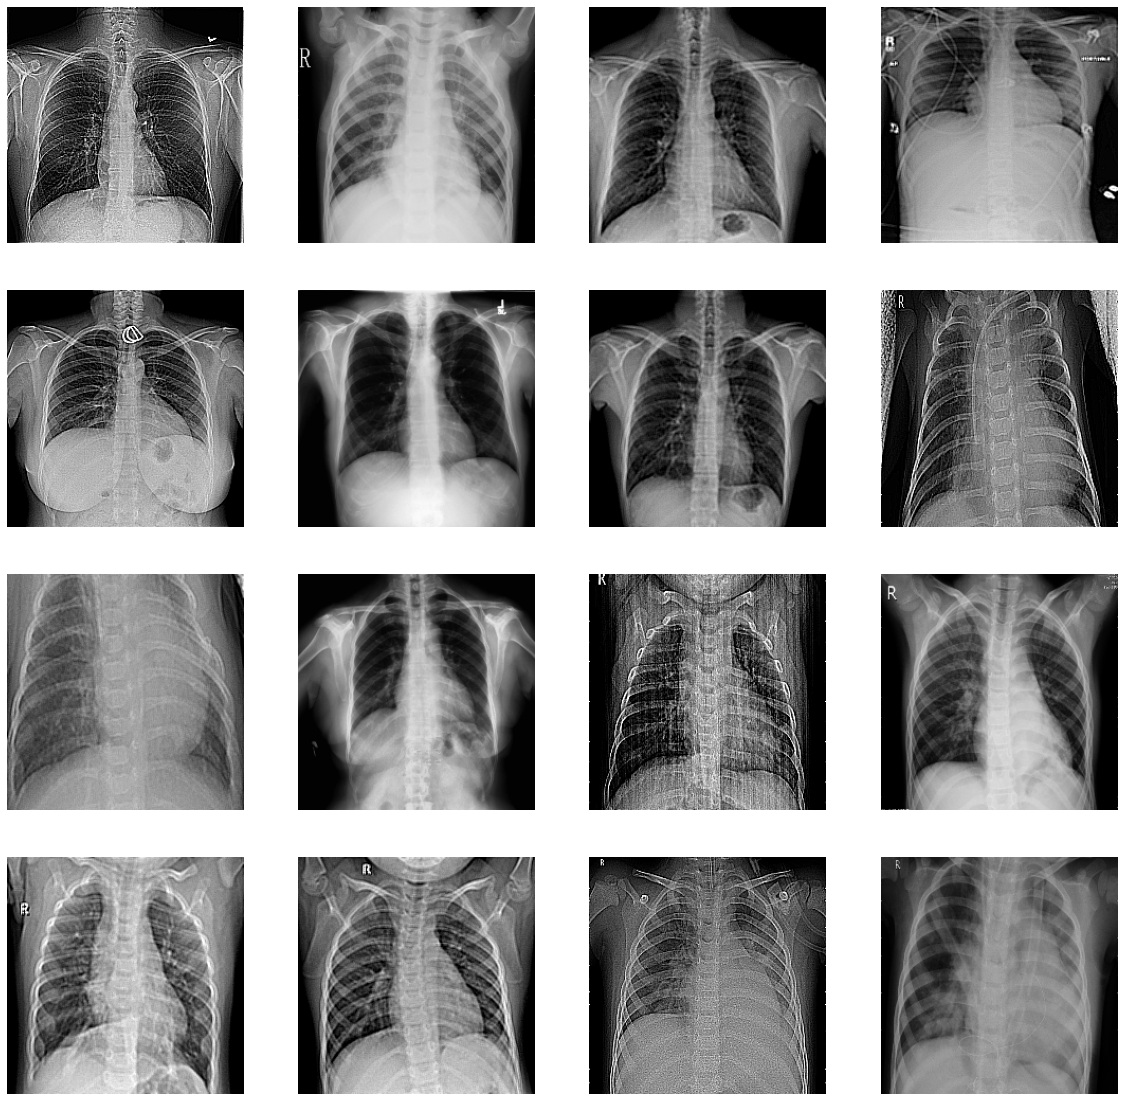

In [39]:
iterator = iter(test_gen)
images = next(iterator)
fig, axis = plt.subplots(4, 4, figsize = (20, 20))

axis = axis.flatten()
ims = images[32:48]
for i in range(ims.shape[0]):
  axis[i].imshow(ims[i].squeeze(), cmap='gray')
  axis[i].set_axis_off()

plt.show()

In [25]:
img_names

['P00009_1.jpeg',
 'P00009_2.jpeg',
 'P00015_1.png',
 'P00015_2.png',
 'P00017_1.png',
 'P00018_1.png',
 'P00019_1.png',
 'P00025_1.png',
 'P00025_2.png',
 'P00028_1.jpeg',
 'P00028_2.jpeg',
 'P00032_1.png',
 'P00032_2.png',
 'P00033_1.jpeg',
 'P00033_2.jpeg',
 'P00041_1.png',
 'P00041_2.png',
 'P00045_1.jpeg',
 'P00045_2.jpeg',
 'P00047_1.png',
 'P00052_1.png',
 'P00052_2.png',
 'P00056_1.jpeg',
 'P00058_1.png',
 'P00061_1.png',
 'P00066_1.png',
 'P00068_1.jpeg',
 'P00068_2.jpeg',
 'P00079_1.png',
 'P00080_1.jpeg',
 'P00080_2.jpeg',
 'P00081_1.png',
 'P00081_2.png',
 'P00083_1.png',
 'P00083_2.png',
 'P00087_1.png',
 'P00087_2.png',
 'P00093_1.jpeg',
 'P00093_2.jpeg',
 'P00096_1.jpeg',
 'P00096_2.jpeg',
 'P00099_1.png',
 'P00101_1.jpeg',
 'P00101_2.jpeg',
 'P00105_1.png',
 'P00112_1.jpeg',
 'P00113_1.png',
 'P00113_2.png',
 'P00115_1.png',
 'P00115_2.png',
 'P00120_1.png',
 'P00120_2.png',
 'P00127_1.png',
 'P00130_1.jpeg',
 'P00140_1.png',
 'P00140_2.png',
 'P00152_1.png',
 'P00152_2

In [26]:
imagesToKeep

['P00009_1.jpeg',
 'P00015_2.png',
 'P00017_1.png',
 'P00018_1.png',
 'P00019_1.png',
 'P00025_2.png',
 'P00028_1.jpeg',
 'P00032_2.png',
 'P00033_1.jpeg',
 'P00041_2.png',
 'P00045_2.jpeg',
 'P00047_1.png',
 'P00052_2.png',
 'P00056_1.jpeg',
 'P00058_1.png',
 'P00061_1.png',
 'P00066_1.png',
 'P00068_2.jpeg',
 'P00079_1.png',
 'P00080_1.jpeg',
 'P00081_1.png',
 'P00083_2.png',
 'P00087_1.png',
 'P00093_1.jpeg',
 'P00096_1.jpeg',
 'P00099_1.png',
 'P00101_1.jpeg',
 'P00105_1.png',
 'P00112_1.jpeg',
 'P00113_2.png',
 'P00115_2.png',
 'P00120_2.png',
 'P00127_1.png',
 'P00130_1.jpeg',
 'P00140_2.png',
 'P00152_2.png',
 'P00159_1.png',
 'P00162_2.png',
 'P00165_2.png',
 'P00173_1.jpeg',
 'P00174_2.jpeg',
 'P00175_1.png',
 'P00176_2.jpeg',
 'P00207_2.jpeg',
 'P00213_1.jpeg',
 'P00215_2.jpeg',
 'P00217_1.jpeg',
 'P00243_1.jpeg',
 'P00246_1.png',
 'P00252_1.png',
 'P00253_1.jpeg',
 'P00257_2.jpeg',
 'P00260_1.png',
 'P00261_1.jpeg',
 'P00263_1.png',
 'P00264_2.png',
 'P00265_2.png',
 'P00269

# CNN-SVM K-fold

In [ ]:
# Define metrics
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
] 

In [ ]:
# load models 
total_model = 5
model_directory = ''
trained_models = list()
for model_n in range(total_model):
  filename = 'final_model/svm_kFold_' + str(model_n+1)
  filename_chosen = os.path.join(model_directory, filename)
  svm_model_loaded = load_model(filename_chosen + '.h5')
  svm_model_loaded.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=METRICS)
  trained_models.append(svm_model_loaded)

##MAJORITY VOTING

In [ ]:
preds = []

for idx, svm_model in enumerate(trained_models):  
  predictions = svm_model.predict(test_gen, use_multiprocessing = True, workers = 8)
  pred = np.argmax(predictions, axis=-1)

  preds.append(pred)

4/4 [==============================] - 167s 3s/step


# Final CSV Buildin

In [ ]:
preds_mv = scipy.stats.mode(preds, axis=0)[0][0]

In [ ]:
print(preds_mv)

[1 0 0 ... 1 0 1]


In [ ]:
preds_mv_labels = [decode(p) for p in preds_mv]

In [ ]:
print(preds_mv_labels)

['P', 'N', 'N', 'N', 'T', 'N', 'P', 'N', 'P', 'N', 'P', 'N', 'N', 'P', 'N', 'N', 'T', 'N', 'N', 'N', 'T', 'N', 'N', 'P', 'P', 'N', 'P', 'T', 'P', 'N', 'N', 'N', 'N', 'P', 'N', 'N', 'N', 'N', 'N', 'P', 'P', 'N', 'P', 'P', 'P', 'N', 'P', 'P', 'N', 'N', 'N', 'P', 'T', 'N', 'N', 'N', 'T', 'P', 'P', 'P', 'T', 'P', 'N', 'P', 'N', 'N', 'P', 'P', 'T', 'N', 'N', 'P', 'P', 'N', 'N', 'P', 'P', 'N', 'P', 'P', 'N', 'P', 'N', 'P', 'P', 'P', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'N', 'N', 'P', 'P', 'N', 'T', 'N', 'P', 'P', 'T', 'T', 'N', 'N', 'N', 'N', 'N', 'P', 'P', 'N', 'T', 'N', 'N', 'P', 'P', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'N', 'N', 'N', 'P', 'N', 'N', 'N', 'N', 'T', 'N', 'N', 'N', 'P', 'P', 'N', 'N', 'N', 'T', 'P', 'N', 'P', 'N', 'T', 'N', 'N', 'N', 'N', 'T', 'N', 'N', 'P', 'P', 'N', 'P', 'N', 'N', 'T', 'N', 'T', 'N', 'T', 'N', 'N', 'T', 'T', 'N', 'N', 'T', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'T', 'P', 'N', 'N', 'P', 'N', 'N', 'T', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'T', 'P', 'N', 'P',

In [ ]:
print(len(preds_mv_labels))

4029


In [ ]:
imagesToKeepOnlyName = [i[:6] for i in imagesToKeep]
labelsDictTemp = {
    'file': imagesToKeepOnlyName,
    'label': preds_mv_labels
}


In [ ]:
labelsDictTemp['file']

In [ ]:
all_labels = []
for idx, img_name in enumerate(img_names):
    id = labelsDictTemp['file'].index(img_name[:6])
    all_labels.append(labelsDictTemp['label'][id])

In [ ]:
finalDict = {
    'file': img_names,
    'label': all_labels
}

In [ ]:
len(all_labels)

5144

In [ ]:
finalCSV = pd.DataFrame.from_dict(finalDict)

In [ ]:
finalCSV

,file,label
0,P00009_1.jpeg,P
1,P00009_2.jpeg,P
2,P00015_1.png,N
3,P00015_2.png,N
4,P00017_1.png,N
...,...,...
5139,P16074_1.jpeg,N
5140,P16084_1.jpeg,P
5141,P16086_1.jpeg,P
5142,P16093_1.png,N


In [ ]:
finalCSV.to_csv('final_model/submission.csv', index=False)

In [ ]:
print(len(img_names))

5144
